In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-3.1.0               |           py36_0         724 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

### get cities and coordinates list for germany big cities from Wiki, and wrangle it

In [2]:
url_wiki = 'https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population'
url_wiki

'https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population'

In [3]:
pd_page = pd.read_html(url_wiki)
df_DE_tops = pd_page[0]
df_DE_tops

,2015rank,City,State,2015Estimate,2011Census,Change,2015land area,2015populationdensity,Location
0,1,Berlin,Berlin,3520031,3292365,+6.91%,891.68 km2344.28 sq mi,"3,948/km210,230/sq mi",52°31′N 13°23′E﻿ / ﻿52.517°N 13.383°E
1,2,Hamburg,Hamburg,1787408,1706696,+4.73%,755.3 km2291.6 sq mi,"2,366/km26,130/sq mi",53°33′N 10°0′E﻿ / ﻿53.550°N 10.000°E
2,3,Munich (München),Bavaria,1450381,1348335,+7.57%,310.7 km2120.0 sq mi,"4,668/km212,090/sq mi",48°8′N 11°34′E﻿ / ﻿48.133°N 11.567°E
3,4,Cologne (Köln),North Rhine-Westphalia,1060582,1005775,+5.45%,405.02 km2156.38 sq mi,"2,619/km26,780/sq mi",50°56′N 6°57′E﻿ / ﻿50.933°N 6.950°E
4,5,Frankfurt am Main,Hesse,732688,667925,+9.70%,248.31 km295.87 sq mi,"2,951/km27,640/sq mi",50°7′N 8°41′E﻿ / ﻿50.117°N 8.683°E
5,6,Stuttgart,Baden-Württemberg,623738,585890,+6.46%,207.35 km280.06 sq mi,"3,008/km27,790/sq mi",48°47′N 9°11′E﻿ / ﻿48.783°N 9.183°E
6,7,Düsseldorf,North Rhine-Westphalia,612178,586291,+4.42%,217.41 km283.94 sq mi,"2,816/km27,290/sq mi",51°14′N 6°47′E﻿ / ﻿51.233°N 6.783°E
7,8,Dortmund,North Rhine-Westphalia,586181,571143,+2.63%,280.71 km2108.38 sq mi,"2,088/km25,410/sq mi",51°31′N 7°28′E﻿ / ﻿51.517°N 7.467°E
8,9,Essen,North Rhine-Westphalia,582624,566201,+2.90%,210.34 km281.21 sq mi,"2,770/km27,200/sq mi",51°27′N 7°1′E﻿ / ﻿51.450°N 7.017°E
9,10,Leipzig,Saxony,560472,502979,+11.43%,297.8 km2115.0 sq mi,"1,882/km24,870/sq mi",51°20′N 12°23′E﻿ / ﻿51.333°N 12.383°E


In [4]:
#select and modify
df_DE_tops = df_DE_tops[['City', '2015Estimate', 'Location']]
df_DE_tops['Location'] = df_DE_tops['Location'].str.strip()
df_temp = df_DE_tops['Location'].str.split('/', n=1, expand=True)
df_temp = df_temp[[1]]
df_temp = df_temp[1].str.split(' ', n=2, expand=True)
df_DE_tops.rename(columns={'2015Estimate':'Population'})
df_temp.drop(columns=[0], axis=1, inplace=True)

#make coordinate readable
for i, row in df_temp.iterrows():
    df_temp.iloc[i] = row.str.replace('\ufeff','')
    df_temp.iloc[i] = row.str.replace('°N','')
    df_temp.iloc[i] = row.str.replace('°E','')
df_temp.rename(columns={1:'latitude', 2:'longitude'}, inplace=True)
df_temp = df_temp.astype(float)

#remove the brackets, only keep germany name
for i, row in df_DE_tops.iterrows():
    if ')' in row['City']:
        row['City'] = row['City'].replace(')','')
        row['City'] = row['City'].split('(')[1]
        df_DE_tops.iloc[i] = row
        
df_DE_tops.drop(columns=['Location'], inplace=True)
df_DE_tops.rename(columns={'2015Estimate':'Population'}, inplace=True)
df_DE_tops = df_DE_tops.join(df_temp)

df_DE_tops

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

,City,Population,latitude,longitude
0,Berlin,3520031,52.51700,13.38300
1,Hamburg,1787408,53.55000,10.00000
2,München,1450381,48.13300,11.56700
3,Köln,1060582,50.93300,6.95000
4,Frankfurt am Main,732688,50.11700,8.68300
5,Stuttgart,623738,48.78300,9.18300
6,Düsseldorf,612178,51.23300,6.78300
7,Dortmund,586181,51.51700,7.46700
8,Essen,582624,51.45000,7.01700
9,Leipzig,560472,51.33300,12.38300


In [5]:
#select out the top15 cities
df_DE_top15 = df_DE_tops.iloc[0:15]
df_DE_top15

,City,Population,latitude,longitude
0,Berlin,3520031,52.517,13.383
1,Hamburg,1787408,53.550,10.000
2,München,1450381,48.133,11.567
3,Köln,1060582,50.933,6.950
4,Frankfurt am Main,732688,50.117,8.683
5,Stuttgart,623738,48.783,9.183
6,Düsseldorf,612178,51.233,6.783
7,Dortmund,586181,51.517,7.467
8,Essen,582624,51.450,7.017
9,Leipzig,560472,51.333,12.383


In [6]:
df_DE_top15.shape

(15, 4)

### set up Foursquare API

In [7]:
CLIENT_ID = 'JCEB5NPQWXQTR2APO0HJYO5QJNGT5FMILY2VKASJQW4OM1I5' # your Foursquare ID
CLIENT_SECRET = 'TITBAUUIRBGXUPWSFPNVPCEHJAQRBB3EN5OFFLKG32VUBI1K' # your Foursquare Secret
VERSION = '20190731'
LIMIT = 300
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JCEB5NPQWXQTR2APO0HJYO5QJNGT5FMILY2VKASJQW4OM1I5
CLIENT_SECRET:TITBAUUIRBGXUPWSFPNVPCEHJAQRBB3EN5OFFLKG32VUBI1K


In [8]:
search_query = 'bubble tea shop'
radius = 100000 #100km
print(search_query + ' .... OK!')

bubble tea shop .... OK!


In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
df_shops_collective = pd.DataFrame()


for i in range(df_DE_top15.shape[0]):
    latitude = df_DE_top15.iloc[i]['latitude']
    longitude = df_DE_top15.iloc[i]['longitude']

    url = 'https://api.foursquare.com/v2/search/recommendations?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()

    try:
        venues = results['response']['group']['results']   
        dataframe = json_normalize(venues)
        
        # keep only columns that include venue name, and anything that is associated with location
        filtered_columns =  ['venue.name', 'venue.categories', 'venue.location.address','venue.location.formattedAddress', 'venue.location.cc', 'venue.location.city', 'venue.location.country', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode','venue.location.state', 'venue.id']

        dataframe_filtered = dataframe.loc[:, filtered_columns]
        # clean column names by keeping only last term
        dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
        dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
        frames = [df_shops_collective, dataframe_filtered]
        df_shops_collective = pd.concat(frames)
        print(df_DE_top15.iloc[i]['City'], ' done')
    
    except:
        print(df_DE_top15.iloc[i]['City'], ' nothing')

df_shops_collective.reset_index(drop=True, inplace=True)
df_shops_collective


Berlin  done
Hamburg  done
München  done
Köln  done
Frankfurt am Main  done
Stuttgart  done
Düsseldorf  done
Dortmund  done
Essen  done


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Leipzig  done
Bremen  done
Dresden  done
Hannover  done
Nürnberg  done
Duisburg  done


,name,categories,address,formattedAddress,cc,city,country,lat,lng,postalCode,state,id
0,ComeBuy Bubble Tea,Bubble Tea Shop,Joachimstaler Str. 14,"[Joachimstaler Str. 14, 10719 Berlin, Deutschl...",DE,Berlin,Deutschland,52.502060,13.331109,10719,Berlin,561a8378498ed6032c81078e
1,ComeBuy Bubble Tea,Bubble Tea Shop,Rosenthaler Str. 31,"[Rosenthaler Str. 31, 10178 Berlin, Deutschland]",DE,Berlin,Deutschland,52.525403,13.403421,10178,Berlin,4ec7c6e0b634b2fd74c12ec9
2,Comebuy Bubble Tea,Bubble Tea Shop,Karl-Liebknecht-Straße 13,"[Karl-Liebknecht-Straße 13, 10178 Berlin, Deut...",DE,Berlin,Deutschland,52.522606,13.407260,10178,Berlin,5b9a9d2dc0f163002cbec5d7
3,Pao Pao,Bubble Tea Shop,Rosentalerstr. 66,"[Rosentalerstr. 66, 10115 Berlin, Deutschland]",DE,Berlin,Deutschland,52.528265,13.402297,10115,Berlin,5cfff0be9cadd9002c5af253
4,Kaffee | Crepes,Bubble Tea Shop,NaN,"[Berlin, Deutschland]",DE,Berlin,Deutschland,52.522351,13.412945,NaN,Berlin,5093c7d2e4b03898af01d7af
5,An’s Tea House,Bubble Tea Shop,Torstrasse 41,"[Torstrasse 41, 10119 Berlin, Deutschland]",DE,Berlin,Deutschland,52.528325,13.411056,10119,Berlin,5c0e4a4fbcbf7a002c353fa6
6,Bubble Tea,Bubble Tea Shop,NaN,"[Berlin, Deutschland]",DE,Berlin,Deutschland,52.499441,13.354418,NaN,Berlin,4eb5a54cf790d87d02d3bb39
7,Asia Bubble Tea,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,52.501904,13.343052,NaN,NaN,59fb167435d3fc1511417ccb
8,ComeBuy Bubble Tea,Bubble Tea Shop,Tamara-Danz-Str. 11,"[Tamara-Danz-Str. 11, Deutschland]",DE,NaN,Deutschland,52.505853,13.445714,NaN,NaN,5be6cb969cadd9002c06ee78
9,Tea One,Bubble Tea Shop,Greifenhagener Str. 33,"[Greifenhagener Str. 33, Berlin, Deutschland]",DE,Berlin,Deutschland,52.552554,13.419631,NaN,Berlin,4ed92dc5e5fa78b16ca7b6e6


### data wranggling

In [11]:
#see if they are all in Germany
print(df_shops_collective.shape)
df_shops_collective.groupby('cc').count()

(75, 12)


,name,categories,address,formattedAddress,city,country,lat,lng,postalCode,state,id
cc,,,,,,,,,,,
AT,1,1,0,1,0,1,1,1,0,0,1
CZ,3,3,3,3,3,3,3,3,3,3,3
DE,70,70,53,70,61,70,70,70,48,61,70
NL,1,1,1,1,1,1,1,1,1,1,1


In [12]:
#remove the other countries
df_shops_collective = df_shops_collective[df_shops_collective['cc'] == 'DE']
df_shops_collective.reset_index(drop=True, inplace=True)
df_shops_collective.shape

(70, 12)

In [13]:
#check if there are repeated shops
df_shops_collective.groupby(['lat','lng']).count()

,,name,categories,address,formattedAddress,cc,city,country,postalCode,state,id
lat,lng,,,,,,,,,,
48.129826,11.575562,1,1,0,1,1,1,1,1,1,1
48.140304,11.559548,1,1,1,1,1,1,1,1,1,1
48.147620,11.464196,1,1,1,1,1,1,1,1,1,1
48.151578,11.576765,1,1,1,1,1,1,1,1,1,1
48.181775,11.443423,1,1,1,1,1,1,1,1,1,1
48.775704,9.173756,1,1,0,1,1,0,1,0,0,1
48.775723,9.174210,1,1,1,1,1,1,1,0,1,1
49.009530,8.405248,1,1,1,1,1,1,1,1,1,1
49.411736,8.707693,2,2,0,2,2,0,2,0,0,2


In [14]:
#see how many shops really are there
print('Number of shops: ',len(df_shops_collective['lat'].unique()))

Number of shops:  46


In [15]:
# drop repeated rows
df_shops_collective.drop_duplicates(subset=['lat'], keep='first', inplace=True)
df_shops_collective.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(46, 12)

In [16]:
#reset index
df_shops_collective.reset_index(drop=True, inplace=True)
df_shops_collective

,name,categories,address,formattedAddress,cc,city,country,lat,lng,postalCode,state,id
0,ComeBuy Bubble Tea,Bubble Tea Shop,Joachimstaler Str. 14,"[Joachimstaler Str. 14, 10719 Berlin, Deutschl...",DE,Berlin,Deutschland,52.502060,13.331109,10719,Berlin,561a8378498ed6032c81078e
1,ComeBuy Bubble Tea,Bubble Tea Shop,Rosenthaler Str. 31,"[Rosenthaler Str. 31, 10178 Berlin, Deutschland]",DE,Berlin,Deutschland,52.525403,13.403421,10178,Berlin,4ec7c6e0b634b2fd74c12ec9
2,Comebuy Bubble Tea,Bubble Tea Shop,Karl-Liebknecht-Straße 13,"[Karl-Liebknecht-Straße 13, 10178 Berlin, Deut...",DE,Berlin,Deutschland,52.522606,13.407260,10178,Berlin,5b9a9d2dc0f163002cbec5d7
3,Pao Pao,Bubble Tea Shop,Rosentalerstr. 66,"[Rosentalerstr. 66, 10115 Berlin, Deutschland]",DE,Berlin,Deutschland,52.528265,13.402297,10115,Berlin,5cfff0be9cadd9002c5af253
4,Kaffee | Crepes,Bubble Tea Shop,NaN,"[Berlin, Deutschland]",DE,Berlin,Deutschland,52.522351,13.412945,NaN,Berlin,5093c7d2e4b03898af01d7af
5,An’s Tea House,Bubble Tea Shop,Torstrasse 41,"[Torstrasse 41, 10119 Berlin, Deutschland]",DE,Berlin,Deutschland,52.528325,13.411056,10119,Berlin,5c0e4a4fbcbf7a002c353fa6
6,Bubble Tea,Bubble Tea Shop,NaN,"[Berlin, Deutschland]",DE,Berlin,Deutschland,52.499441,13.354418,NaN,Berlin,4eb5a54cf790d87d02d3bb39
7,Asia Bubble Tea,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,52.501904,13.343052,NaN,NaN,59fb167435d3fc1511417ccb
8,ComeBuy Bubble Tea,Bubble Tea Shop,Tamara-Danz-Str. 11,"[Tamara-Danz-Str. 11, Deutschland]",DE,NaN,Deutschland,52.505853,13.445714,NaN,NaN,5be6cb969cadd9002c06ee78
9,Tea One,Bubble Tea Shop,Greifenhagener Str. 33,"[Greifenhagener Str. 33, Berlin, Deutschland]",DE,Berlin,Deutschland,52.552554,13.419631,NaN,Berlin,4ed92dc5e5fa78b16ca7b6e6


### fetch the number of tips and rating signals seen as a pointer of popularity

In [17]:
#get number of tips and ratings from Foursquare
tips_count_list = []
rating_signals_list = []

for ind, shop_id in zip(df_shops_collective.index, df_shops_collective.id):
    venue_id_for_each = shop_id
    url_for_each = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id_for_each, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url_for_each).json()
    tips_count_list.append(result['response']['venue']['tips']['count'])
    try:
        rating_signals_list.append(result['response']['venue']['ratingSignals'])
    except:
        rating_signals_list.append(0)


In [18]:
print(tips_count_list)
print(rating_signals_list)

[3, 54, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 1, 2, 0, 4, 5, 1, 1, 1, 1, 0, 1, 7, 0, 1, 3, 0, 0, 1, 0, 0, 4, 0, 1, 1, 1, 0, 1, 0, 0]
[37, 259, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 23, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [19]:
#add ratings and tips

pop_pointer = []
for i, j in zip(tips_count_list, rating_signals_list):
    pop_pointer.append(i+j)

print(pop_pointer)

[40, 313, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 1, 2, 0, 27, 28, 1, 1, 1, 1, 0, 1, 17, 0, 1, 3, 0, 0, 1, 0, 0, 4, 0, 1, 1, 1, 0, 1, 0, 0]


In [20]:
len(pop_pointer)

46

In [21]:
# merge the pop_pointer to main dataframe
try:
    df_shops_collective.drop(columns=['pointer'], axis=1, inplace =True)
except:
    pass
df_shops_collective['pointer'] = pd.Series(pop_pointer)
df_shops_collective

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,categories,address,formattedAddress,cc,city,country,lat,lng,postalCode,state,id,pointer
0,ComeBuy Bubble Tea,Bubble Tea Shop,Joachimstaler Str. 14,"[Joachimstaler Str. 14, 10719 Berlin, Deutschl...",DE,Berlin,Deutschland,52.502060,13.331109,10719,Berlin,561a8378498ed6032c81078e,40
1,ComeBuy Bubble Tea,Bubble Tea Shop,Rosenthaler Str. 31,"[Rosenthaler Str. 31, 10178 Berlin, Deutschland]",DE,Berlin,Deutschland,52.525403,13.403421,10178,Berlin,4ec7c6e0b634b2fd74c12ec9,313
2,Comebuy Bubble Tea,Bubble Tea Shop,Karl-Liebknecht-Straße 13,"[Karl-Liebknecht-Straße 13, 10178 Berlin, Deut...",DE,Berlin,Deutschland,52.522606,13.407260,10178,Berlin,5b9a9d2dc0f163002cbec5d7,1
3,Pao Pao,Bubble Tea Shop,Rosentalerstr. 66,"[Rosentalerstr. 66, 10115 Berlin, Deutschland]",DE,Berlin,Deutschland,52.528265,13.402297,10115,Berlin,5cfff0be9cadd9002c5af253,1
4,Kaffee | Crepes,Bubble Tea Shop,NaN,"[Berlin, Deutschland]",DE,Berlin,Deutschland,52.522351,13.412945,NaN,Berlin,5093c7d2e4b03898af01d7af,0
5,An’s Tea House,Bubble Tea Shop,Torstrasse 41,"[Torstrasse 41, 10119 Berlin, Deutschland]",DE,Berlin,Deutschland,52.528325,13.411056,10119,Berlin,5c0e4a4fbcbf7a002c353fa6,0
6,Bubble Tea,Bubble Tea Shop,NaN,"[Berlin, Deutschland]",DE,Berlin,Deutschland,52.499441,13.354418,NaN,Berlin,4eb5a54cf790d87d02d3bb39,1
7,Asia Bubble Tea,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,52.501904,13.343052,NaN,NaN,59fb167435d3fc1511417ccb,0
8,ComeBuy Bubble Tea,Bubble Tea Shop,Tamara-Danz-Str. 11,"[Tamara-Danz-Str. 11, Deutschland]",DE,NaN,Deutschland,52.505853,13.445714,NaN,NaN,5be6cb969cadd9002c06ee78,0
9,Tea One,Bubble Tea Shop,Greifenhagener Str. 33,"[Greifenhagener Str. 33, Berlin, Deutschland]",DE,Berlin,Deutschland,52.552554,13.419631,NaN,Berlin,4ed92dc5e5fa78b16ca7b6e6,1


In [22]:
#sorted by pointer, highest first
df_shops_collective_sorted = df_shops_collective.sort_values(by = ['pointer'], ascending=False)
df_shops_collective_sorted.reset_index(drop=True, inplace=True)
df_shops_collective_sorted


,name,categories,address,formattedAddress,cc,city,country,lat,lng,postalCode,state,id,pointer
0,ComeBuy Bubble Tea,Bubble Tea Shop,Rosenthaler Str. 31,"[Rosenthaler Str. 31, 10178 Berlin, Deutschland]",DE,Berlin,Deutschland,52.525403,13.403421,10178,Berlin,4ec7c6e0b634b2fd74c12ec9,313
1,ComeBuy Bubble Tea,Bubble Tea Shop,Joachimstaler Str. 14,"[Joachimstaler Str. 14, 10719 Berlin, Deutschl...",DE,Berlin,Deutschland,52.502060,13.331109,10719,Berlin,561a8378498ed6032c81078e,40
2,sphere bay,Bubble Tea Shop,Immermannstr. 29,"[Immermannstr. 29 (Oststr.), 40210 Düsseldorf,...",DE,Düsseldorf,Deutschland,51.223733,6.787875,40210,Nordrhein-Westfalen,4f5cbb95e4b02628c23716e1,28
3,teamate,Bubble Tea Shop,Immermannstr. 65C,"[Immermannstr. 65C (Karlstr.), 40210 Düsseldor...",DE,Düsseldorf,Deutschland,51.221648,6.791776,40210,Nordrhein-Westfalen,57375b8b498ebbf2491e8f81,27
4,Na Na,Bubble Tea Shop,Schweizer Strasse 73,"[Schweizer Strasse 73, 60594 Frankfurt am Main...",DE,Frankfurt am Main,Deutschland,50.100432,8.682099,60594,Hessen,4fa8f6b3e4b099106f6163dc,17
5,Tea Time,Juice Bar,Wandsbeker Marktstraße 141,"[Wandsbeker Marktstraße 141, 22041 Hamburg, De...",DE,Hamburg,Deutschland,53.573097,10.076248,22041,Hamburg,4c0018b0ceabb71397c98752,4
6,Yobu,Juice Bar,NaN,"[Leipzig, Deutschland]",DE,Leipzig,Deutschland,51.344756,12.381624,NaN,Sachsen,4f7715bde4b08e5a674572fa,4
7,Teeseele,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,49.411736,8.707693,NaN,NaN,5cb343076adbf5002cc10d00,3
8,TeaTime - Milk Tea & Smoothies,Bubble Tea Shop,Türkenstraße 69,"[Türkenstraße 69, 80799 München, Deutschland]",DE,München,Deutschland,48.151578,11.576765,80799,Bayern,5c7fb923340a58002cea01db,2
9,Teespresso,Bubble Tea Shop,Lange Strasse,"[Lange Strasse, Stuttgart, Deutschland]",DE,Stuttgart,Deutschland,48.775723,9.174210,NaN,BADEN-WÜRTEMBEEG,5b43434bc58ed7002c08f02d,1


In [23]:
#label them into 4 classes, 0 the best, 3 the worst
label = []

for i in range(df_shops_collective_sorted.shape[0]):
    if df_shops_collective_sorted.iloc[i]['pointer'] > 15:
        label.append(0)
    elif df_shops_collective_sorted.iloc[i]['pointer'] > 1:
        label.append(1)
    elif df_shops_collective_sorted.iloc[i]['pointer'] > 0:
        label.append(2)
    else:
        label.append(3)

print(label)


[0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [24]:
#add label back to dataframe
try:
    df_shops_collective_sorted.drop(columns=['label'], axis=1, inplace =True)
except:
    pass

df_shops_collective_sorted['label'] = pd.Series(label)
df_shops_collective_sorted

,name,categories,address,formattedAddress,cc,city,country,lat,lng,postalCode,state,id,pointer,label
0,ComeBuy Bubble Tea,Bubble Tea Shop,Rosenthaler Str. 31,"[Rosenthaler Str. 31, 10178 Berlin, Deutschland]",DE,Berlin,Deutschland,52.525403,13.403421,10178,Berlin,4ec7c6e0b634b2fd74c12ec9,313,0
1,ComeBuy Bubble Tea,Bubble Tea Shop,Joachimstaler Str. 14,"[Joachimstaler Str. 14, 10719 Berlin, Deutschl...",DE,Berlin,Deutschland,52.502060,13.331109,10719,Berlin,561a8378498ed6032c81078e,40,0
2,sphere bay,Bubble Tea Shop,Immermannstr. 29,"[Immermannstr. 29 (Oststr.), 40210 Düsseldorf,...",DE,Düsseldorf,Deutschland,51.223733,6.787875,40210,Nordrhein-Westfalen,4f5cbb95e4b02628c23716e1,28,0
3,teamate,Bubble Tea Shop,Immermannstr. 65C,"[Immermannstr. 65C (Karlstr.), 40210 Düsseldor...",DE,Düsseldorf,Deutschland,51.221648,6.791776,40210,Nordrhein-Westfalen,57375b8b498ebbf2491e8f81,27,0
4,Na Na,Bubble Tea Shop,Schweizer Strasse 73,"[Schweizer Strasse 73, 60594 Frankfurt am Main...",DE,Frankfurt am Main,Deutschland,50.100432,8.682099,60594,Hessen,4fa8f6b3e4b099106f6163dc,17,0
5,Tea Time,Juice Bar,Wandsbeker Marktstraße 141,"[Wandsbeker Marktstraße 141, 22041 Hamburg, De...",DE,Hamburg,Deutschland,53.573097,10.076248,22041,Hamburg,4c0018b0ceabb71397c98752,4,1
6,Yobu,Juice Bar,NaN,"[Leipzig, Deutschland]",DE,Leipzig,Deutschland,51.344756,12.381624,NaN,Sachsen,4f7715bde4b08e5a674572fa,4,1
7,Teeseele,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,49.411736,8.707693,NaN,NaN,5cb343076adbf5002cc10d00,3,1
8,TeaTime - Milk Tea & Smoothies,Bubble Tea Shop,Türkenstraße 69,"[Türkenstraße 69, 80799 München, Deutschland]",DE,München,Deutschland,48.151578,11.576765,80799,Bayern,5c7fb923340a58002cea01db,2,1
9,Teespresso,Bubble Tea Shop,Lange Strasse,"[Lange Strasse, Stuttgart, Deutschland]",DE,Stuttgart,Deutschland,48.775723,9.174210,NaN,BADEN-WÜRTEMBEEG,5b43434bc58ed7002c08f02d,1,2


### visualize

In [25]:
map_lat = 51.163361
map_lng = 10.447683
class_number = 4

# create map
map_clusters = folium.Map(location=[map_lat, map_lng], zoom_start=5, tiles="Stamen Toner")

# set color scheme for the clusters
x = np.arange(class_number)
ys = [i + x + (i*x)**2 for i in range(class_number)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nm, cls in zip(df_shops_collective_sorted['lat'], df_shops_collective_sorted['lng'], df_shops_collective_sorted['name'], df_shops_collective_sorted['label']):
    label = folium.Popup(str(nm) + ' (Class ' + str(cls) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4*(class_number - cls),
        popup=label,
        color=rainbow[cls-1],
        fill=True,
        fill_color=rainbow[cls-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### the bigger the points are, the hotter the bubble tea shops are

### fetch the nearby venues of all bubble tea shops

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        #print(venues_list)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Shop', 
                  'Shop Latitude', 
                  'Shop Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)

In [28]:
#fetch from foursquare
shopnearby_venues = getNearbyVenues(names=df_shops_collective_sorted['name'],
                                   latitudes=df_shops_collective_sorted['lat'],
                                   longitudes=df_shops_collective_sorted['lng']
                                  )

ComeBuy Bubble Tea
ComeBuy Bubble Tea
sphere bay
teamate
Na Na
Tea Time
Yobu
Teeseele
TeaTime - Milk Tea & Smoothies
Teespresso
Tea One
Comebuy
Shiso's Boba Station
Yaa! Bubbletea & More
Dim Sum Tea House
Casa Rosi
Comebuy
Crazy Tea
Teeseele
Fei Chic Flagship Store Düsseldorf
Comebuy Bubble Tea
Pao Pao
Bubble Tea
Tea One
Teepause
veg-ana Tee Online Shop Bio
Asia Bubble Tea
Tea & Shirt Beatrix Greif-Domin
DrinkBubble
Kaffee | Crepes
An’s Tea House
The Amitea
Comebuy
POP Bubbletea
Teepresso
Monchi Tea
ComeBuy Bubble Tea
Micha Bubble Tea Station
Tea One
Tokas
Bubble Tea BoBoQ Am Hauptbahnhof
Moc
Bobbies Icehouse
Q Tea
Bubble Kiss
el bosque


In [29]:
print(shopnearby_venues.shape)
shopnearby_venues.head()

(3242, 7)


,Shop,Shop Latitude,Shop Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ComeBuy Bubble Tea,52.525403,13.403421,BEN RAHIM,52.525168,13.401928,Coffee Shop
1,ComeBuy Bubble Tea,52.525403,13.403421,Die Hackeschen Höfe,52.524094,13.402157,Monument / Landmark
2,ComeBuy Bubble Tea,52.525403,13.403421,Sophiensaele,52.526031,13.401385,Dance Studio
3,ComeBuy Bubble Tea,52.525403,13.403421,Neurotitan,52.524488,13.401809,Art Gallery
4,ComeBuy Bubble Tea,52.525403,13.403421,Casa Camper Boutique Hotel Berlin Mitte,52.525799,13.403818,Hotel


In [30]:
# see them by group-by
shopnearby_venues.groupby(['Shop Latitude', 'Shop']).count()

,,Shop Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Shop Latitude,Shop,,,,,
48.129826,Q Tea,95,95,95,95,95
48.140304,Bubble Kiss,79,79,79,79,79
48.147620,Teepause,56,56,56,56,56
48.151578,TeaTime - Milk Tea & Smoothies,81,81,81,81,81
48.181775,veg-ana Tee Online Shop Bio,5,5,5,5,5
48.775704,Teepresso,100,100,100,100,100
48.775723,Teespresso,100,100,100,100,100
49.009530,POP Bubbletea,88,88,88,88,88
49.411736,Teeseele,63,63,63,63,63


In [31]:
#see how many categories are there
print('There are {} uniques categories.'.format(len(shopnearby_venues['Venue Category'].unique())))

There are 278 uniques categories.


### refine data frame by city, in order to fetch the city list as test set (which has no bubble tea yet)

In [32]:
# cities which have no description in city
df_refine = df_shops_collective_sorted[df_shops_collective_sorted['city'].isna()]
df_refine

,name,categories,address,formattedAddress,cc,city,country,lat,lng,postalCode,state,id,pointer,label
7,Teeseele,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,49.411736,8.707693,NaN,NaN,5cb343076adbf5002cc10d00,3,1
17,Crazy Tea,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,49.473009,10.988298,NaN,NaN,4f632e05e4b02ac2c3cbbe19,1,2
26,Asia Bubble Tea,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,52.501904,13.343052,NaN,NaN,59fb167435d3fc1511417ccb,0,3
31,The Amitea,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,51.065264,13.749793,NaN,NaN,5ce2d229135b39002cf843bf,0,3
34,Teepresso,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,48.775704,9.173756,NaN,NaN,5d21fbb0be636e0023a98fdc,0,3
36,ComeBuy Bubble Tea,Bubble Tea Shop,Tamara-Danz-Str. 11,"[Tamara-Danz-Str. 11, Deutschland]",DE,NaN,Deutschland,52.505853,13.445714,NaN,NaN,5be6cb969cadd9002c06ee78,0,3
37,Micha Bubble Tea Station,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,49.999893,8.273759,NaN,NaN,4f5b6c15e4b01219ab18dae6,0,3
45,el bosque,Bubble Tea Shop,NaN,[Deutschland],DE,NaN,Deutschland,50.235336,10.959237,NaN,NaN,538bb81c498e34b97ad70650,0,3


In [33]:
# find cities for those shops which were not assigned
geolocator_for_addr = Nominatim(user_agent="addr_loc")
city_tops = df_DE_tops['City'].to_list()
city_dict_refine = {}

for ind, row in df_refine.iterrows():
    k_temp = 0
    lat = row['lat']
    lng = row['lng']
    loc = str(lat) + ' , ' + str(lng)
    location = geolocator_for_addr.reverse(loc)
    addr = location.address.split(',')
    addr = list(map(str.strip, addr))
    for city_temp in addr:
        if city_temp in city_tops:
            city_dict_refine.update({ind:city_temp})
        else:
            pass

city_dict_refine

{7: 'Heidelberg',
 17: 'Fürth',
 26: 'Berlin',
 31: 'Dresden',
 34: 'Stuttgart',
 36: 'Berlin',
 37: 'Mainz'}

In [34]:
# import back to data frame
for ind in city_dict_refine:
    df_shops_collective_sorted.set_value(ind, 'city', city_dict_refine[ind])
    
df_shops_collective_sorted

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


,name,categories,address,formattedAddress,cc,city,country,lat,lng,postalCode,state,id,pointer,label
0,ComeBuy Bubble Tea,Bubble Tea Shop,Rosenthaler Str. 31,"[Rosenthaler Str. 31, 10178 Berlin, Deutschland]",DE,Berlin,Deutschland,52.525403,13.403421,10178,Berlin,4ec7c6e0b634b2fd74c12ec9,313,0
1,ComeBuy Bubble Tea,Bubble Tea Shop,Joachimstaler Str. 14,"[Joachimstaler Str. 14, 10719 Berlin, Deutschl...",DE,Berlin,Deutschland,52.502060,13.331109,10719,Berlin,561a8378498ed6032c81078e,40,0
2,sphere bay,Bubble Tea Shop,Immermannstr. 29,"[Immermannstr. 29 (Oststr.), 40210 Düsseldorf,...",DE,Düsseldorf,Deutschland,51.223733,6.787875,40210,Nordrhein-Westfalen,4f5cbb95e4b02628c23716e1,28,0
3,teamate,Bubble Tea Shop,Immermannstr. 65C,"[Immermannstr. 65C (Karlstr.), 40210 Düsseldor...",DE,Düsseldorf,Deutschland,51.221648,6.791776,40210,Nordrhein-Westfalen,57375b8b498ebbf2491e8f81,27,0
4,Na Na,Bubble Tea Shop,Schweizer Strasse 73,"[Schweizer Strasse 73, 60594 Frankfurt am Main...",DE,Frankfurt am Main,Deutschland,50.100432,8.682099,60594,Hessen,4fa8f6b3e4b099106f6163dc,17,0
5,Tea Time,Juice Bar,Wandsbeker Marktstraße 141,"[Wandsbeker Marktstraße 141, 22041 Hamburg, De...",DE,Hamburg,Deutschland,53.573097,10.076248,22041,Hamburg,4c0018b0ceabb71397c98752,4,1
6,Yobu,Juice Bar,NaN,"[Leipzig, Deutschland]",DE,Leipzig,Deutschland,51.344756,12.381624,NaN,Sachsen,4f7715bde4b08e5a674572fa,4,1
7,Teeseele,Bubble Tea Shop,NaN,[Deutschland],DE,Heidelberg,Deutschland,49.411736,8.707693,NaN,NaN,5cb343076adbf5002cc10d00,3,1
8,TeaTime - Milk Tea & Smoothies,Bubble Tea Shop,Türkenstraße 69,"[Türkenstraße 69, 80799 München, Deutschland]",DE,München,Deutschland,48.151578,11.576765,80799,Bayern,5c7fb923340a58002cea01db,2,1
9,Teespresso,Bubble Tea Shop,Lange Strasse,"[Lange Strasse, Stuttgart, Deutschland]",DE,Stuttgart,Deutschland,48.775723,9.174210,NaN,BADEN-WÜRTEMBEEG,5b43434bc58ed7002c08f02d,1,2


### fetch list and data for those cities which will be used as test set

In [35]:
#create list for all cities
city_tops = df_DE_tops['City'].to_list()
print(city_tops)

['Berlin', 'Hamburg', 'München', 'Köln', 'Frankfurt am Main', 'Stuttgart', 'Düsseldorf', 'Dortmund', 'Essen', 'Leipzig', 'Bremen', 'Dresden', 'Hannover', 'Nürnberg', 'Duisburg', 'Bochum', 'Wuppertal', 'Bielefeld', 'Bonn', 'Münster', 'Karlsruhe', 'Mannheim', 'Augsburg', 'Wiesbaden', 'Gelsenkirchen', 'Mönchengladbach', 'Braunschweig', 'Chemnitz', 'Kiel', 'Aachen', 'Saale', 'Magdeburg', 'Freiburg im Breisgau', 'Krefeld', 'Lübeck', 'Oberhausen', 'Erfurt', 'Mainz', 'Rostock', 'Kassel', 'Hagen', 'Hamm', 'Saarbrücken', 'Mülheim an der Ruhr', 'Potsdam', 'Ludwigshafen am Rhein', 'Oldenburg', 'Leverkusen', 'Osnabrück', 'Solingen', 'Heidelberg', 'Herne', 'Neuss', 'Darmstadt', 'Paderborn', 'Regensburg', 'Ingolstadt', 'Würzburg', 'Fürth', 'Wolfsburg', 'Offenbach am Main', 'Ulm', 'Heilbronn', 'Pforzheim', 'Göttingen', 'Bottrop', 'Trier', 'Recklinghausen', 'Reutlingen', 'Bremerhaven', 'Koblenz', 'Bergisch Gladbach', 'Jena', 'Remscheid', 'Erlangen', 'Moers', 'Siegen', 'Hildesheim', 'Salzgitter']


In [36]:
#filter out the cities which have no bubble tea shop yet
city_to_be_check_list = []

city_already_in = list(df_shops_collective_sorted['city'].unique())

for i in city_tops:
    if i in city_already_in:
        pass
    else:
        city_to_be_check_list.append(i)

print(city_to_be_check_list)

['Essen', 'Bremen', 'Duisburg', 'Bochum', 'Wuppertal', 'Bielefeld', 'Bonn', 'Münster', 'Augsburg', 'Gelsenkirchen', 'Mönchengladbach', 'Braunschweig', 'Chemnitz', 'Kiel', 'Aachen', 'Saale', 'Magdeburg', 'Freiburg im Breisgau', 'Krefeld', 'Lübeck', 'Oberhausen', 'Erfurt', 'Rostock', 'Kassel', 'Hagen', 'Hamm', 'Saarbrücken', 'Mülheim an der Ruhr', 'Potsdam', 'Ludwigshafen am Rhein', 'Oldenburg', 'Leverkusen', 'Osnabrück', 'Solingen', 'Herne', 'Neuss', 'Darmstadt', 'Paderborn', 'Regensburg', 'Ingolstadt', 'Würzburg', 'Wolfsburg', 'Offenbach am Main', 'Ulm', 'Heilbronn', 'Pforzheim', 'Göttingen', 'Bottrop', 'Trier', 'Recklinghausen', 'Reutlingen', 'Bremerhaven', 'Koblenz', 'Bergisch Gladbach', 'Jena', 'Remscheid', 'Erlangen', 'Moers', 'Siegen', 'Hildesheim', 'Salzgitter']


In [37]:
#select the other top 15
city_to_be_check_list = city_to_be_check_list[0:15]
city_to_be_check_list

['Essen',
 'Bremen',
 'Duisburg',
 'Bochum',
 'Wuppertal',
 'Bielefeld',
 'Bonn',
 'Münster',
 'Augsburg',
 'Gelsenkirchen',
 'Mönchengladbach',
 'Braunschweig',
 'Chemnitz',
 'Kiel',
 'Aachen']

In [38]:
df_cities_TBC = df_DE_tops[df_DE_tops['City'].isin(city_to_be_check_list)]
df_cities_TBC

,City,Population,latitude,longitude
8,Essen,582624,51.450,7.017
10,Bremen,557464,53.083,8.800
14,Duisburg,491231,51.433,6.767
15,Bochum,364742,51.483,7.217
16,Wuppertal,350046,51.267,7.183
17,Bielefeld,333090,52.017,8.533
18,Bonn,318809,50.733,7.100
19,Münster,310039,51.967,7.633
22,Augsburg,286374,48.367,10.900
24,Gelsenkirchen,260368,51.517,7.100


In [39]:
#we will analyse the central of each city as a reference, hbf is the main station

hbf_lat = []
hbf_lng = []

for ind, row in df_cities_TBC.iterrows():
    address = 'Hbf, ' + row['City']

    geolocator = Nominatim(user_agent="TBC_agent")
    location = geolocator.geocode(address)
    hbf_lat.append(location.latitude)
    hbf_lng.append(location.longitude)

In [41]:
# see the coordinates
print(hbf_lat)
print(hbf_lng)

[51.4514769, 53.5345819, 51.43181285, 51.47739835, 51.25511545, 52.02857835, 50.7321134, 51.9563344, 48.3658618, 51.5047677, 51.1967199, 52.2523572, 50.8371062, 54.3134463, 50.7674944]
[7.0144679, 8.59774863211943, 6.77662737631579, 7.21854482950755, 7.15122361895449, 8.53301853814208, 7.0981956, 7.6333106, 10.8888341, 7.1022983, 6.4462733, 10.5386981, 12.9292667, 10.1310136, 6.0892113]


In [42]:
#add them back to data frame
df_cities_TBC['hbf_lat'] = np.asarray(hbf_lat)
df_cities_TBC['hbf_lng'] = np.asarray(hbf_lng)
df_cities_TBC.reset_index(drop=True, inplace=True)
df_cities_TBC

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,City,Population,latitude,longitude,hbf_lat,hbf_lng
0,Essen,582624,51.450,7.017,51.451477,7.014468
1,Bremen,557464,53.083,8.800,53.534582,8.597749
2,Duisburg,491231,51.433,6.767,51.431813,6.776627
3,Bochum,364742,51.483,7.217,51.477398,7.218545
4,Wuppertal,350046,51.267,7.183,51.255115,7.151224
5,Bielefeld,333090,52.017,8.533,52.028578,8.533019
6,Bonn,318809,50.733,7.100,50.732113,7.098196
7,Münster,310039,51.967,7.633,51.956334,7.633311
8,Augsburg,286374,48.367,10.900,48.365862,10.888834
9,Gelsenkirchen,260368,51.517,7.100,51.504768,7.102298


In [43]:
# fetch venues nearby them
Cities_TBC_venues = getNearbyVenues(names=df_cities_TBC['City'],
                                   latitudes=df_cities_TBC['hbf_lat'],
                                   longitudes=df_cities_TBC['hbf_lng']
                                  )

Essen
Bremen
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Münster
Augsburg
Gelsenkirchen
Mönchengladbach
Braunschweig
Chemnitz
Kiel
Aachen


In [44]:
# check and modify the fetched data
Cities_TBC_venues.rename(columns={"Shop": "City", "Shop Latitude": "HBF Latitude", "Shop Longitude": "HBF Longitude"}, inplace=True)
print(Cities_TBC_venues.shape)
Cities_TBC_venues.head(10)


(494, 7)


,City,HBF Latitude,HBF Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Essen,51.451477,7.014468,Astra Theater,51.453142,7.014241,Indie Movie Theater
1,Essen,51.451477,7.014468,Daktari Cocktailbar,51.448623,7.013032,Cocktail Bar
2,Essen,51.451477,7.014468,Bolia – New Scandinavian Design,51.453412,7.012960,Furniture / Home Store
3,Essen,51.451477,7.014468,Pfefferkorn,51.454346,7.012483,Steakhouse
4,Essen,51.451477,7.014468,Tablo,51.449228,7.012306,Middle Eastern Restaurant
5,Essen,51.451477,7.014468,Lichtburg,51.454842,7.012971,Movie Theater
6,Essen,51.451477,7.014468,LUSH,51.451332,7.014003,Cosmetics Shop
7,Essen,51.451477,7.014468,sattgrün,51.453956,7.011326,Vegetarian / Vegan Restaurant
8,Essen,51.451477,7.014468,Grillo-Theater,51.454623,7.012504,Theater
9,Essen,51.451477,7.014468,Hotel Essener Hof,51.452842,7.014697,Hotel


In [45]:
#see the numbers of venues nearby
Cities_TBC_venues.groupby('City').count()

,HBF Latitude,HBF Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Aachen,24,24,24,24,24,24
Augsburg,37,37,37,37,37,37
Bielefeld,34,34,34,34,34,34
Bochum,44,44,44,44,44,44
Bonn,67,67,67,67,67,67
Braunschweig,24,24,24,24,24,24
Bremen,8,8,8,8,8,8
Chemnitz,24,24,24,24,24,24
Duisburg,31,31,31,31,31,31


### prepare for machine learning

In [46]:
#combine two data frame, in order to create a common category

frames_combine = [shopnearby_venues[['Shop Latitude','Venue Category']].rename(columns={'Shop Latitude':'Latitude'}), Cities_TBC_venues[['HBF Latitude', 'Venue Category']].rename(columns={'HBF Latitude':'Latitude'})]

df_cat_combined = pd.concat(frames_combine)


In [47]:
print(df_cat_combined.shape)
df_cat_combined.head()

(3736, 2)


,Latitude,Venue Category
0,52.525403,Coffee Shop
1,52.525403,Monument / Landmark
2,52.525403,Dance Studio
3,52.525403,Art Gallery
4,52.525403,Hotel


In [48]:
print('There are {} uniques categories.'.format(len(df_cat_combined['Venue Category'].unique())))

There are 288 uniques categories.


In [49]:
# one hot encoding, split the categories
cat_combined_onehot = pd.get_dummies(df_cat_combined[['Venue Category']], prefix="", prefix_sep="")
cat_combined_onehot.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Candy Store,Cantonese Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Cultural Center,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Liquor Store,Lounge,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Rhenisch Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Re

In [50]:
# add latitude column back to dataframe, like an index

try:
    cat_combined_onehot.drop(columns=['Latitude'], axis=1, inplace=True)
except:
    pass
cat_lat_list = df_cat_combined['Latitude']
cat_combined_onehot.insert(0, 'Latitude', cat_lat_list)
cat_combined_onehot.head(10)

,Latitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Candy Store,Cantonese Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Cultural Center,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Liquor Store,Lounge,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Rhenisch Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vacation Rental,Vegetarian /

In [51]:
#group by latitude, which will be unique
cat_combined_grouped = cat_combined_onehot.groupby('Latitude').mean().reset_index()
cat_combined_grouped

,Latitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Candy Store,Cantonese Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Cultural Center,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Liquor Store,Lounge,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Rhenisch Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vacation Rental,Vegetarian /

In [52]:
#throw the above dataframe back to each, in order to seperate train and test set

#import by the latitude
df_cat_for_shops = pd.merge(df_shops_collective_sorted[['name','lat','city','label']].rename(columns={'lat':'Latitude'}), cat_combined_grouped, on='Latitude')

#remove this, because it looks like a repeated item
try:
    df_cat_for_shops = df_cat_for_shops[df_cat_for_shops.name != 'Teepresso']
except:
    pass

df_cat_for_shops.reset_index(drop=True, inplace=True)
df_cat_for_shops


,name,Latitude,city,label,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Candy Store,Cantonese Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Cultural Center,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Liquor Store,Lounge,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Rhenisch Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vacation Ren

In [53]:
#do the same for the other city list, test set
df_cat_for_cities = pd.merge(df_cities_TBC[['City','hbf_lat']].rename(columns={'hbf_lat':'Latitude'}), cat_combined_grouped, on='Latitude')
df_cat_for_cities


,City,Latitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Candy Store,Cantonese Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Cultural Center,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Liquor Store,Lounge,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Rhenisch Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vacation Rental,Vegetar

In [54]:
#function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
#create the top 10 venues for each shops

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Shop', 'City', 'Latitude']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
shops_venues_sorted = pd.DataFrame(columns=columns)
shops_venues_sorted['Shop'] = df_cat_for_shops['name']
shops_venues_sorted['City'] = df_cat_for_shops['city']
shops_venues_sorted['Latitude'] = df_cat_for_shops['Latitude']

for ind in np.arange(df_cat_for_shops.shape[0]):
    shops_venues_sorted.iloc[ind, 3:] = return_most_common_venues(df_cat_for_shops.iloc[ind, :], num_top_venues)

shops_venues_sorted.head(10)

,Shop,City,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ComeBuy Bubble Tea,Berlin,52.525403,Clothing Store,Coffee Shop,Hotel,Café,Italian Restaurant,Optical Shop,Ice Cream Shop,Vietnamese Restaurant,Yoga Studio,Boutique
1,ComeBuy Bubble Tea,Berlin,52.502060,Hotel,Clothing Store,Italian Restaurant,Movie Theater,Burger Joint,Café,German Restaurant,Furniture / Home Store,Steakhouse,French Restaurant
2,sphere bay,Düsseldorf,51.223733,Japanese Restaurant,Korean Restaurant,Hotel,Chinese Restaurant,Ramen Restaurant,Café,Grocery Store,Italian Restaurant,Clothing Store,Coffee Shop
3,teamate,Düsseldorf,51.221648,Hotel,Japanese Restaurant,Korean Restaurant,Ramen Restaurant,Chinese Restaurant,Café,Turkish Restaurant,Grocery Store,Coffee Shop,Italian Restaurant
4,Na Na,Frankfurt am Main,50.100432,German Restaurant,Café,Park,Italian Restaurant,Falafel Restaurant,Eastern European Restaurant,Organic Grocery,Supermarket,Sushi Restaurant,Bar
5,Tea Time,Hamburg,53.573097,label,Bakery,Chinese Restaurant,Hotel,Bavarian Restaurant,Italian Restaurant,Steakhouse,Sushi Restaurant,German Restaurant,Spanish Restaurant
6,Yobu,Leipzig,51.344756,label,Hotel,Coffee Shop,Japanese Restaurant,Shopping Mall,Drugstore,Tram Station,Bistro,Hostel,Indian Restaurant
7,Teeseele,Heidelberg,49.411736,label,Bar,Plaza,Hotel,Ice Cream Shop,German Restaurant,Café,Burger Joint,Japanese Restaurant,Falafel Restaurant
8,TeaTime - Milk Tea & Smoothies,München,48.151578,label,Café,Bar,Italian Restaurant,Ice Cream Shop,Mediterranean Restaurant,Vietnamese Restaurant,Cocktail Bar,Burger Joint,Art Museum
9,Teespresso,Stuttgart,48.775723,label,Bar,German Restaurant,Café,Italian Restaurant,Clothing Store,Sushi Restaurant,Coffee Shop,Steakhouse,Plaza


### machine learning - decision tree for classification

In [56]:
#dependent variable
df_y = df_cat_for_shops['label']
df_y[0:5]

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [57]:
#independent variables
df_X = df_cat_for_shops.drop(columns = ['name','Latitude','city','label'])
df_X.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Candy Store,Cantonese Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Cultural Center,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Liquor Store,Lounge,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Rhenisch Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Re

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
#split into train and test set
X_trainset, X_testset, y_trainset, y_testset = train_test_split(df_X, df_y, test_size=0.15, random_state=3)
print('X train: ' + str(X_trainset.shape) + ', y train: ' + str(y_trainset.shape))

X train: (38, 288), y train: (38,)


In [60]:
from sklearn.tree import DecisionTreeClassifier

In [84]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [86]:
VenueTree = DecisionTreeClassifier(criterion="entropy", max_depth = 12)
VenueTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [87]:
VenueTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [88]:
predTree = VenueTree.predict(X_testset)

In [89]:
print (predTree [0:5])
print (list(y_testset [0:5]))

[3 0 0 3 1]
[2, 3, 2, 2, 2]


In [90]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.2857142857142857


Max of mean accuracy (test): 0.2857142857142857
---------
Best Depth K for test: 6
Best Depth K for test: 7
Best Depth K for test: 8
Best Depth K for test: 12


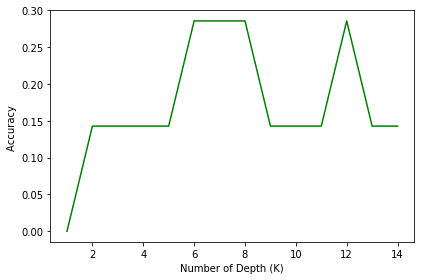

In [85]:
#see which depth will be better
K_DecTree = 15

mean_acc_DecTree = np.zeros((K_DecTree-1))

for i in range(1,K_DecTree):
    VenueTree = DecisionTreeClassifier(criterion="entropy", max_depth = i)
    VenueTree.fit(X_trainset,y_trainset)
    predTree = VenueTree.predict(X_testset)
    #predTree_train = drugTree.predict(X_train)
    mean_acc_DecTree[i-1] = metrics.accuracy_score(y_testset, predTree)
    #mean_acc_DecTree_train[i-1] = metrics.accuracy_score(y_train, predTree_train)

print("Max of mean accuracy (test): "+str(max(mean_acc_DecTree)))
print('---------')

for i in range(0,K_DecTree-1):
    if mean_acc_DecTree[i] == max(mean_acc_DecTree):
        print('Best Depth K for test: '+str(i+1))

plt.plot(range(1,K_DecTree),mean_acc_DecTree,'g')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Depth (K)')
plt.tight_layout()
plt.show()

### set up test set

In [95]:
df_X_for_cities = df_cat_for_cities.drop(columns = ['City','Latitude'])
df_X_for_cities.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Candy Store,Cantonese Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Cultural Center,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Liquor Store,Lounge,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Rhenisch Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Re

In [96]:
#predict for test set
predTree_for_cities = VenueTree.predict(df_X_for_cities)
predTree_for_cities

array([3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1])

In [97]:
#add result to data frame
df_cities_TBC.reset_index(drop=True, inplace=True)
df_cities_TBC['label'] = pd.Series(predTree_for_cities)
df_cities_TBC.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,City,Population,latitude,longitude,hbf_lat,hbf_lng,label
0,Essen,582624,51.450,7.017,51.451477,7.014468,3
1,Bremen,557464,53.083,8.800,53.534582,8.597749,3
2,Duisburg,491231,51.433,6.767,51.431813,6.776627,3
3,Bochum,364742,51.483,7.217,51.477398,7.218545,3
4,Wuppertal,350046,51.267,7.183,51.255115,7.151224,3


In [98]:
#sort them by label
df_cities_TBC.sort_values(by=['label'], ascending=True)

,City,Population,latitude,longitude,hbf_lat,hbf_lng,label
14,Aachen,245885,50.783,6.083,50.767494,6.089211,1
6,Bonn,318809,50.733,7.100,50.732113,7.098196,2
8,Augsburg,286374,48.367,10.900,48.365862,10.888834,2
0,Essen,582624,51.450,7.017,51.451477,7.014468,3
1,Bremen,557464,53.083,8.800,53.534582,8.597749,3
2,Duisburg,491231,51.433,6.767,51.431813,6.776627,3
3,Bochum,364742,51.483,7.217,51.477398,7.218545,3
4,Wuppertal,350046,51.267,7.183,51.255115,7.151224,3
5,Bielefeld,333090,52.017,8.533,52.028578,8.533019,3
7,Münster,310039,51.967,7.633,51.956334,7.633311,3


In [99]:
#visualize them

map_lat = 51.163361
map_lng = 10.447683
class_number = 4

# create map
map_clusters_2 = folium.Map(location=[map_lat, map_lng], zoom_start=5, tiles="Stamen Toner")

# set color scheme for the clusters
x = np.arange(class_number)
ys = [i + x + (i*x)**2 for i in range(class_number)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nm, cls in zip(df_cities_TBC['latitude'], df_cities_TBC['longitude'], df_cities_TBC['City'], df_cities_TBC['label']):
    label = folium.Popup(str(nm) + ' (Class ' + str(cls) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4*(class_number - cls),
        #radius=5,
        popup=label,
        color=rainbow[cls-1],
        fill=True,
        fill_color=rainbow[cls-1],
        fill_opacity=0.7).add_to(map_clusters_2)
       
map_clusters_2

In [100]:
#data wrangling for venues distribution

try:
    df_cat_for_cities.drop(columns = ['label'], inplace=True)
    df_cat_for_cities.drop(columns = ['label2'], inplace=True)
except:
    pass
df_cat_for_cities.insert(2, 'label', predTree_for_cities)
df_cat_for_cities.head()

,City,Latitude,label,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Candy Store,Cantonese Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Cultural Center,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Liquor Store,Lounge,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Rhenisch Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vacation Rental,V

In [361]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City', 'Latitude', 'Label']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = df_cat_for_cities['City']
cities_venues_sorted['Latitude'] = df_cat_for_cities['Latitude']
cities_venues_sorted['Label'] = df_cat_for_cities['label']

for ind in np.arange(df_cat_for_cities.shape[0]):
    cities_venues_sorted.iloc[ind, 3:] = return_most_common_venues(df_cat_for_cities.iloc[ind, :], num_top_venues)

cities_venues_sorted.head(10)

,City,Latitude,Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Essen,51.451477,3,Hotel,Italian Restaurant,Bakery,Drugstore,Plaza,Coffee Shop,Cocktail Bar,Clothing Store,Vegetarian / Vegan Restaurant,Seafood Restaurant
1,Bremen,53.534582,3,Restaurant,Asian Restaurant,Gym / Fitness Center,Convenience Store,Hotel,Drugstore,Train Station,Yoga Studio,Donut Shop,Dumpling Restaurant
2,Duisburg,51.431813,3,Fast Food Restaurant,Hotel,Bakery,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bus Stop,Sandwich Place,Doner Restaurant,Drugstore
3,Bochum,51.477398,2,Café,Bookstore,Vietnamese Restaurant,Supermarket,Bakery,Greek Restaurant,Asian Restaurant,German Restaurant,Market,Taverna
4,Wuppertal,51.255115,1,Hotel,Drugstore,Café,Supermarket,Clothing Store,Ice Cream Shop,Platform,Bakery,Thai Restaurant,Modern European Restaurant
5,Bielefeld,52.028578,3,Bar,Hotel,Nightclub,Burger Joint,Drugstore,Middle Eastern Restaurant,Supermarket,Asian Restaurant,Shopping Mall,Sushi Restaurant
6,Bonn,50.732113,2,Café,Plaza,Pub,Italian Restaurant,Grocery Store,Bar,Clothing Store,Bakery,Cocktail Bar,German Restaurant
7,Münster,51.956334,3,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Doner Restaurant,Bus Station,Board Shop,Greek Restaurant,Theater,Mobile Phone Shop,Bank
8,Augsburg,48.365862,2,Bakery,Hotel,Brewery,Pub,Café,Coffee Shop,Plaza,Dessert Shop,Mobile Phone Shop,Nightclub
9,Gelsenkirchen,51.504768,3,Drugstore,Clothing Store,Supermarket,Ice Cream Shop,Bakery,Restaurant,Department Store,Sandwich Place,Pedestrian Plaza,Doner Restaurant


In [365]:
cities_venues_sorted.drop(columns=['Latitude'], inplace=True)
cities_venues_sorted.sort_values(by=['Label'], ascending=True)

,City,Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Wuppertal,1,Hotel,Drugstore,Café,Supermarket,Clothing Store,Ice Cream Shop,Platform,Bakery,Thai Restaurant,Modern European Restaurant
14,Aachen,1,Bakery,Fast Food Restaurant,Drugstore,Vietnamese Restaurant,Italian Restaurant,Convenience Store,Pizza Place,Bar,Supermarket,Chinese Restaurant
3,Bochum,2,Café,Bookstore,Vietnamese Restaurant,Supermarket,Bakery,Greek Restaurant,Asian Restaurant,German Restaurant,Market,Taverna
6,Bonn,2,Café,Plaza,Pub,Italian Restaurant,Grocery Store,Bar,Clothing Store,Bakery,Cocktail Bar,German Restaurant
8,Augsburg,2,Bakery,Hotel,Brewery,Pub,Café,Coffee Shop,Plaza,Dessert Shop,Mobile Phone Shop,Nightclub
0,Essen,3,Hotel,Italian Restaurant,Bakery,Drugstore,Plaza,Coffee Shop,Cocktail Bar,Clothing Store,Vegetarian / Vegan Restaurant,Seafood Restaurant
1,Bremen,3,Restaurant,Asian Restaurant,Gym / Fitness Center,Convenience Store,Hotel,Drugstore,Train Station,Yoga Studio,Donut Shop,Dumpling Restaurant
2,Duisburg,3,Fast Food Restaurant,Hotel,Bakery,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bus Stop,Sandwich Place,Doner Restaurant,Drugstore
5,Bielefeld,3,Bar,Hotel,Nightclub,Burger Joint,Drugstore,Middle Eastern Restaurant,Supermarket,Asian Restaurant,Shopping Mall,Sushi Restaurant
7,Münster,3,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Doner Restaurant,Bus Station,Board Shop,Greek Restaurant,Theater,Mobile Phone Shop,Bank
